C:\Users\jan-gabriel.hartel\AppData\Local\Temp\ipykernel_14576\2448496422.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_values, y_values, cmap='viridis', s=5)


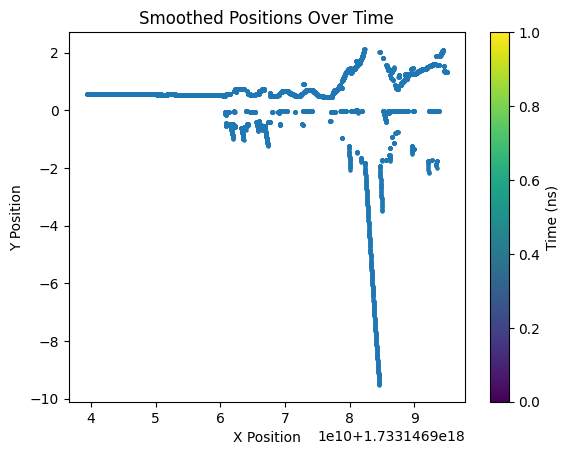

In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load from csv
final_df = pd.read_csv("output/final_states.csv")

# Convert smoothed_positions to a NumPy array
smoothed_positions_array = np.array(final_df)

# Extract x and y values
x_values = smoothed_positions_array[:, 0]
y_values = smoothed_positions_array[:, 1]

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x_values, y_values, cmap="viridis", s=5)
plt.colorbar(scatter, label="Time (ns)")
ax.set_title("Smoothed Positions Over Time")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
plt.show()

In [ ]:
import cv2
import numpy as np
import pandas as pd

recording = NeonRecording(dataset_dir)

# Assume `all_detections` and `results` DataFrames are given.
# all_detections: columns ['frame_idx', 'tag_id', 'corners']
# results: columns ['frame_idx', 'camera_pos'] where camera_pos is [x, y, z]

# Create quick lookups
results_dict = {
    row["frame_idx"]: row["smoothed_camera_pos"] for _, row in final_results.iterrows()
}

detections_by_frame = {}
for _, row in all_detections.iterrows():
    fidx = row["frame_idx"]
    if fidx not in detections_by_frame:
        detections_by_frame[fidx] = []
    detections_by_frame[fidx].append((row["tag_id"], row["corners"]))

cap = recording.video

frame_idx = 0

# Track last known detections and positions
last_detections = None
last_position = None
ever_detected = False

# Precompute min/max for scaling the graph
min_x, max_x = np.inf, -np.inf
min_y, max_y = np.inf, -np.inf

if len(results) > 0:
    all_positions = np.vstack(results["camera_pos"])
    min_x, max_x = np.min(all_positions[:, 0]), np.max(all_positions[:, 0])
    min_y, max_y = np.min(all_positions[:, 1]), np.max(all_positions[:, 1])

# Handle degenerate ranges
if min_x == max_x:
    max_x = min_x + 1.0
if min_y == max_y:
    max_y = min_y + 1.0

# Inset graph size
graph_width = 300
graph_height = 300

# Store all visited positions to show them dimly
visited_positions = []


def draw_detections(frame, detections, color, thickness=2):
    for tag_id, corners in detections:
        corners_int = corners.astype(int)
        cv2.polylines(frame, [corners_int], True, color, thickness)
        for c in corners_int:
            cv2.circle(frame, tuple(c), 4, color, -1)
        corner_text_pos = (corners_int[0, 0], corners_int[0, 1] - 10)
        cv2.putText(
            frame,
            f"ID: {tag_id}",
            corner_text_pos,
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
        )


def position_to_graph_coords(position, x0, y0, w, h, min_x, max_x, min_y, max_y):
    x, y, z = position
    x_norm = (x - min_x) / (max_x - min_x)
    y_norm = (y - min_y) / (max_y - min_y)
    pt_x = int(x0 + x_norm * w)
    pt_y = int(y0 + (1 - y_norm) * h)
    return (pt_x, pt_y)


def draw_coordinate_cross(frame, x0, y0, w, h, min_x, max_x, min_y, max_y):
    # Draw a black background
    cv2.rectangle(frame, (x0, y0), (x0 + w, y0 + h), (0, 0, 0), -1)

    # Only draw axes if 0,0 is within the range
    if min_x < 0 < max_x and min_y < 0 < max_y:
        # Find the coordinates of the origin in the graph
        origin = position_to_graph_coords(
            (0, 0, 0), x0, y0, w, h, min_x, max_x, min_y, max_y
        )

        line_color = (200, 200, 200)
        thickness = 1

        # Draw x-axis line (horizontal) across entire width
        cv2.line(frame, (x0, origin[1]), (x0 + w, origin[1]), line_color, thickness)

        # Draw y-axis line (vertical) across entire height
        cv2.line(frame, (origin[0], y0), (origin[0], y0 + h), line_color, thickness)


def draw_mini_graph(
    frame, current_position, detected, visited_positions, min_x, max_x, min_y, max_y
):
    h, w = frame.shape[:2]
    x0 = w - graph_width - 10
    y0 = h - graph_height - 10

    # Draw coordinate cross background and axes
    draw_coordinate_cross(
        frame, x0, y0, graph_width, graph_height, min_x, max_x, min_y, max_y
    )

    # Draw all previously visited positions in a dim color
    dim_color = (100, 100, 100)
    for pos in visited_positions:
        pt = position_to_graph_coords(
            pos, x0, y0, graph_width, graph_height, min_x, max_x, min_y, max_y
        )
        cv2.circle(frame, pt, 3, dim_color, -1)

    # Draw the current position if available
    if current_position is not None:
        pt = position_to_graph_coords(
            current_position,
            x0,
            y0,
            graph_width,
            graph_height,
            min_x,
            max_x,
            min_y,
            max_y,
        )
        color = (0, 255, 0) if detected else (0, 0, 255)
        cv2.circle(frame, pt, 5, color, -1)


# Try reading a test frame to get video size
ret, test_frame = cap.read()
if not ret:
    print("Could not read frame to determine size.")
    cap.release()
    exit()
height, width = test_frame.shape[:2]

# Reset video to start
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Initialize VideoWriter to save output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0:
    fps = 30  # fallback if FPS is not available
out = cv2.VideoWriter("output_with_overlays.mp4", fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video")
        break

    current_detections = detections_by_frame.get(frame_idx, None)
    current_position = results_dict.get(frame_idx, None)

    if current_position is not None:
        # Store current position for future reference
        visited_positions.append(current_position)

    if current_detections is not None:
        # We have current detections
        ever_detected = True
        last_detections = current_detections
        last_position = (
            current_position if current_position is not None else last_position
        )

        # Draw detections in green
        draw_detections(frame, current_detections, (0, 255, 0))

        # Mini graph with current position in green
        draw_mini_graph(
            frame, current_position, True, visited_positions, min_x, max_x, min_y, max_y
        )
    else:
        # No current detections
        if ever_detected and last_detections is not None:
            # Draw last known detections in red
            draw_detections(frame, last_detections, (0, 0, 255))

            # Mini graph with last known position in red
            draw_mini_graph(
                frame,
                last_position,
                False,
                visited_positions,
                min_x,
                max_x,
                min_y,
                max_y,
            )
        else:
            # Never had any detections: draw a green overlay
            overlay = frame.copy()
            cv2.rectangle(
                overlay,
                (0, 0),
                (frame.shape[1], frame.shape[0]),
                (0, 255, 0),
                thickness=20,
            )
            alpha = 0.2
            frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
            # If we do have a last known position, still show it in green
            draw_mini_graph(
                frame,
                last_position,
                True,
                visited_positions,
                min_x,
                max_x,
                min_y,
                max_y,
            )

    cv2.imshow("Video with Overlays", frame)
    out.write(frame)

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

    frame_idx += 1

cap.release()
out.release()
cv2.destroyAllWindows()

End of video


: 